# Predicting Student Test Scores - Basic EDA
This is an EDA notebook for Kaggle's playground January 2026 competition, "Predicting Student Test Scores". This basic EDA is the first EDA I perform in every tabular data competition. It shows:
* is column Categorical or Numeric
* how many unique values per column
* how many nan values per column
* distribution of column values
* relationship between column and target

Discussion about this notebook is [here][1]

[1]: https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665965

# Load Train Data

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s6e1/train.csv")
print(f"Train shape: {train.shape}")
train.head()

Train shape: (630000, 13)


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


# Basic EDA Function
The following function was written by ChatGPT 5.2. It plots the relationship between features and target. And it plots the distrubtion of feature values. These insights can help us build models.

In [2]:
def plot_features_dual_axis(
    df: pd.DataFrame,
    cols: list[str],
    target_col: str,
    n_bins: int = 10,
    n_wide: int = 3,
    figsize_per_plot: tuple[float, float] = (5, 4),
    int_as_cat_unique_max: int | None = 20,
    cat_order: dict[str, list] | None = None,   # <-- NEW
):
    BAR_COLOR = "tab:blue"
    LINE_COLOR = "tab:orange"

    def is_categorical(s: pd.Series) -> bool:
        return s.dtype == "object" or pd.api.types.is_string_dtype(s)

    n_cols = len(cols)
    n_rows = int(np.ceil(n_cols / n_wide))

    fig, axes = plt.subplots(
        n_rows,
        n_wide,
        figsize=(figsize_per_plot[0] * n_wide, figsize_per_plot[1] * n_rows),
    )

    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols):
        ax1 = axes[i]
        col_safe = col.replace("_", r"\_")

        n_nan = df[col].isna().sum()
        n_unique = df[col].nunique(dropna=True)

        tmp = df[[col, target_col]].dropna()
        if tmp.empty:
            ax1.set_title(
                rf"$\bf{{{col_safe}}}$"
                f"\n(empty after dropna; {n_unique} unique, {n_nan} nan)"
            )
            continue

        x = tmp[col]
        y = tmp[target_col]

        # ---------- TRUE CATEGORICAL ----------
        if is_categorical(x):
            type_str = "categorical"

            # base counts / means
            counts = x.value_counts()
            mean_y = tmp.groupby(col)[target_col].mean()

            # ---- APPLY USER-DEFINED CATEGORY ORDER (if provided) ----
            if cat_order is not None and col in cat_order:
                desired = list(cat_order[col])

                # keep only categories present in data
                ordered = [c for c in desired if c in counts.index]

                # append any remaining categories not specified by user
                remaining = [c for c in counts.index if c not in ordered]
                final_order = ordered + remaining
            else:
                final_order = sorted(counts.index)

            counts = counts.loc[final_order]
            mean_y = mean_y.loc[final_order]

            xpos = np.arange(len(final_order))

            ax1.bar(xpos, counts.values, alpha=0.6, color=BAR_COLOR)
            ax1.set_xlabel(col)
            ax1.set_ylabel("Count", color=BAR_COLOR)
            ax1.tick_params(axis="y", colors=BAR_COLOR)

            ax1.set_xticks(xpos)
            ax1.set_xticklabels(final_order, rotation=45, ha="right")

            ax2 = ax1.twinx()
            ax2.plot(xpos, mean_y.values, marker="o", color=LINE_COLOR)
            ax2.set_ylabel(f"Mean {target_col}", color=LINE_COLOR)
            ax2.tick_params(axis="y", colors=LINE_COLOR)

            ax1.set_title(
                rf"$\bf{{{col_safe}}}$: Count vs Mean {target_col}"
                f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
            )

        # ---------- NUMERIC ----------
        else:
            type_str = "numeric"

            xvals = x.values
            yvals = y.values

            mask = np.isfinite(xvals) & np.isfinite(yvals)
            xvals = xvals[mask]
            yvals = yvals[mask]

            if len(xvals) == 0:
                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )
                continue

            unique_vals = np.sort(np.unique(xvals))
            n_unique_eff = len(unique_vals)

            # --- Case 1: int-as-categorical ---
            if int_as_cat_unique_max is not None and n_unique_eff <= int_as_cat_unique_max:
                counts = np.array([(xvals == v).sum() for v in unique_vals])
                mean_y = np.array([yvals[xvals == v].mean() for v in unique_vals])

                xpos = np.arange(n_unique_eff)

                ax1.bar(xpos, counts, alpha=0.6, color=BAR_COLOR)
                ax1.set_xlabel(col)
                ax1.set_ylabel("Count", color=BAR_COLOR)
                ax1.tick_params(axis="y", colors=BAR_COLOR)

                rotate = 45 if n_unique_eff > n_bins else 0
                step = max(int(np.ceil(n_unique_eff / n_bins)), 1)
                tick_idx = np.arange(0, n_unique_eff, step)

                if pd.api.types.is_integer_dtype(x):
                    tick_labels = unique_vals[tick_idx].astype(int)
                else:
                    tick_labels = unique_vals[tick_idx]

                ax1.set_xticks(tick_idx)
                ax1.set_xticklabels(
                    tick_labels,
                    rotation=rotate,
                    ha="right" if rotate else "center",
                )

                ax2 = ax1.twinx()
                ax2.plot(xpos, mean_y, marker="o", color=LINE_COLOR)
                ax2.set_ylabel(f"Mean {target_col}", color=LINE_COLOR)
                ax2.tick_params(axis="y", colors=LINE_COLOR)

                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$: Per-Value Count vs Mean {target_col}"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )

            # --- Case 2: low-cardinality numeric bins ---
            elif n_unique_eff < n_bins:
                counts = np.array([(xvals == v).sum() for v in unique_vals])
                mean_y = np.array([yvals[xvals == v].mean() for v in unique_vals])

                width = 0.8 * (np.min(np.diff(unique_vals)) if n_unique_eff > 1 else 1.0)

                ax1.bar(unique_vals, counts, width=width, alpha=0.6, color=BAR_COLOR)
                ax1.set_xlabel(col)
                ax1.set_ylabel("Count", color=BAR_COLOR)
                ax1.tick_params(axis="y", colors=BAR_COLOR)

                ax2 = ax1.twinx()
                ax2.plot(unique_vals, mean_y, marker="o", color=LINE_COLOR)
                ax2.set_ylabel(f"Mean {target_col}", color=LINE_COLOR)
                ax2.tick_params(axis="y", colors=LINE_COLOR)

                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$: Per-Value Count vs Mean {target_col}"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )

            # --- Case 3: regular histogram ---
            else:
                bins = np.linspace(xvals.min(), xvals.max(), n_bins + 1)
                bin_centers = 0.5 * (bins[:-1] + bins[1:])

                counts, _ = np.histogram(xvals, bins=bins)
                bin_idx = np.digitize(xvals, bins) - 1

                mean_y = np.array([
                    yvals[bin_idx == j].mean() if np.any(bin_idx == j) else np.nan
                    for j in range(n_bins)
                ])

                ax1.bar(
                    bin_centers,
                    counts,
                    width=(bins[1] - bins[0]),
                    alpha=0.6,
                    color=BAR_COLOR,
                )
                ax1.set_xlabel(col)
                ax1.set_ylabel("Count", color=BAR_COLOR)
                ax1.tick_params(axis="y", colors=BAR_COLOR)

                ax2 = ax1.twinx()
                ax2.plot(bin_centers, mean_y, marker="o", color=LINE_COLOR)
                ax2.set_ylabel(f"Mean {target_col}", color=LINE_COLOR)
                ax2.tick_params(axis="y", colors=LINE_COLOR)

                ax1.set_title(
                    rf"$\bf{{{col_safe}}}$: Histogram vs Mean {target_col}"
                    f"\n({type_str} with {n_unique} unique and {n_nan} nan)"
                )

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Display EDA

In [3]:
FEATURES = list( train.columns[1:-1] )
print(f"There are {len(FEATURES)} features:")
print(FEATURES)

There are 11 features:
['age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


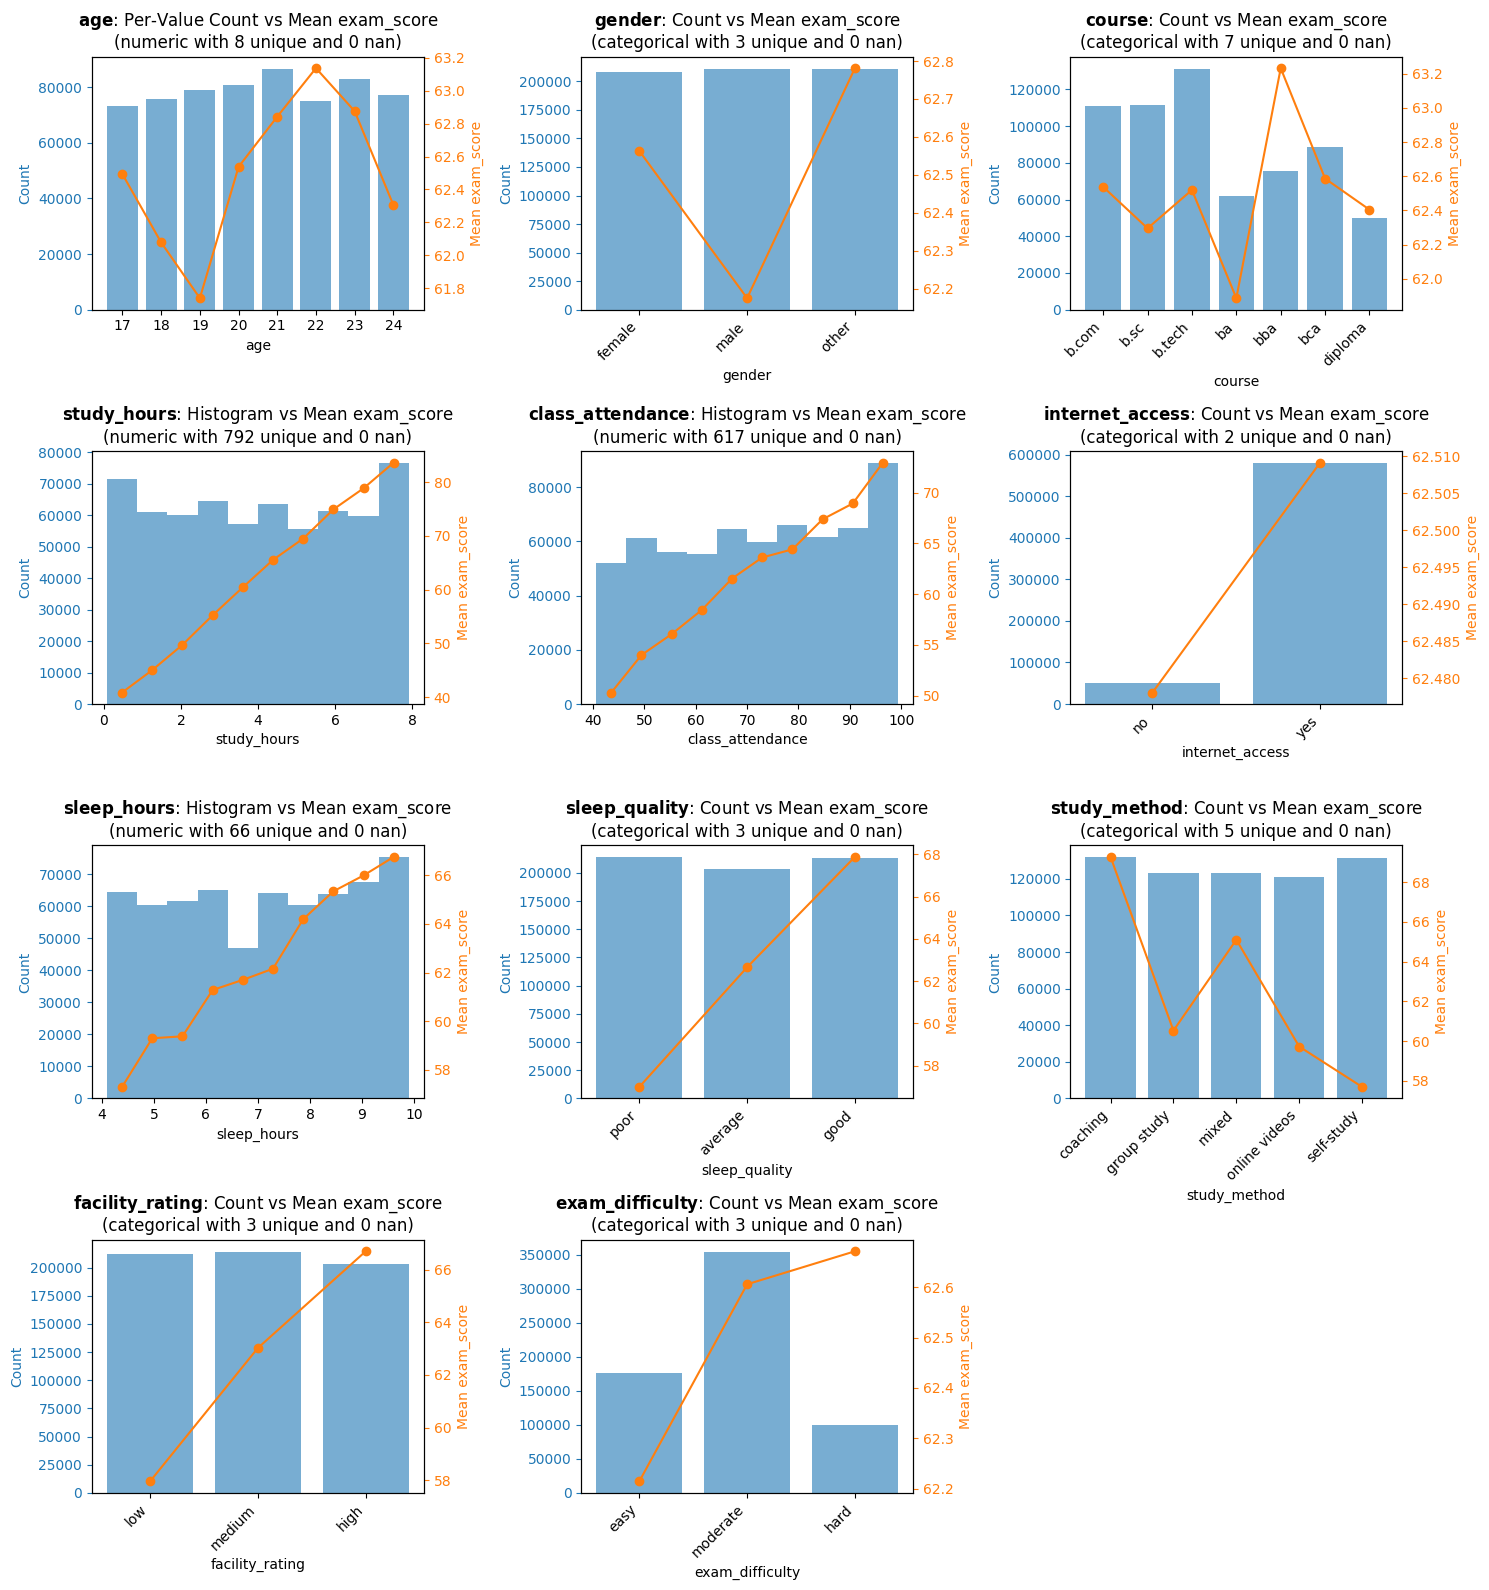

In [4]:
ordinal_order = {
    "sleep_quality":["poor","average","good"],
    "facility_rating":["low","medium","high"],
    "exam_difficulty":["easy","moderate","hard"],
}

plot_features_dual_axis(
    train,
    cols=FEATURES,
    target_col="exam_score",
    n_bins=10,
    n_wide=3,
    int_as_cat_unique_max=20,
    cat_order = ordinal_order,
)

# Conclusions
From the above EDA we observe the following:
* No columns have nan values
* Age is low cardinality numeric which can be treated as categorical
* Many categorical features have ordinal classes  
* Many features have a nearly uniform linear distribution (i.e. columns don't have rare values with exception of internet access)
* Many features have a linear relationship with target. Namely study_hours, class_attendance, sleep_hours, sleep_quality, facility_rating.
* The other features seem to have a non linear relationship with target
* All features appear to be predictive of target

The presence of strong linear relationships suggest building non linear models over the residuals of linear models. Next step EDA would be to explore interactions between features. How does one feature affect the relationship between another feature and target? The complexity of interactions can help us decide how to best use NN, GBDT, and stacking.